## Step 0. Import Packages & Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# change root to the necessary path
root = "/gdrive/MyDrive/ads_proj4/ads-spring-2022-prj4-group-11-1/"
outputs_dir = root + "output/"
lib_dir = root + "lib/"

assert os.path.exists(root), 'Check the path to your root directory'
assert os.path.exists(outputs_dir), 'Check the path to your outputs directory'
assert os.path.exists(lib_dir), 'Check the path to your lib directory'

sys.path.append(lib_dir)

## Step 1. Data Processing

In [4]:
# loading data
compas = pd.read_csv(outputs_dir + 'ffs_data_v3.csv', header=0,
                     dtype = {'age_cat': int,'race': int,
                              'priors_count': int,'length_of_stay': int})
compas.head()

,age,c_charge_degree,race,sex,priors_count,length_of_stay,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count
0,34,F,0,Male,0,1,1,0,0,0
1,24,F,0,Male,2,0,1,0,0,1
2,41,F,1,Male,2,0,1,0,0,0
3,39,M,1,Female,0,0,0,0,0,0
4,27,F,1,Male,0,0,0,0,0,0


In [5]:
compas['c_charge_degree'] = pd.get_dummies(compas['c_charge_degree'])['F'] # 1 if felony, 0 if misdemeanor
compas['sex'] = pd.get_dummies(compas['sex'])['Male'] # 1 if male, 0 if female

juv_cond = (compas['juv_fel_count'] > 0) | (compas['juv_misd_count'] > 0) | (compas['juv_other_count'] > 0)
compas['has_juv'] = np.where(juv_cond, 1, 0)
compas['has_prior'] = np.where(compas['priors_count'] > 0, 1, 0)
compas.head()

,age,c_charge_degree,race,sex,priors_count,length_of_stay,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,has_juv,has_prior
0,34,1,0,1,0,1,1,0,0,0,0,0
1,24,1,0,1,2,0,1,0,0,1,1,1
2,41,1,1,1,2,0,1,0,0,0,0,1
3,39,0,1,0,0,0,0,0,0,0,0,0
4,27,1,1,1,0,0,0,0,0,0,0,0


In [6]:
X = compas[['age', 'c_charge_degree', 'sex', 'priors_count', 'length_of_stay', 
            'has_juv', 'has_prior']]
y = compas['two_year_recid']
protected = compas['race']

## Step 2. FFS: Computing Accuracy and Discrimination Shapley scores

Please run `run_ffs.py` to get the shapley scores for the features.

In [7]:
scores = pd.read_csv(outputs_dir + 'ffs_scores.csv', header=0)
scores

,Feature,Accuracy,Discrimination
0,age,2.387480,7151227.848
1,c_charge_degree,0.914765,3708267.395
2,sex,0.831752,3222794.890
3,priors_count,0.440957,1117870.972
4,length_of_stay,0.642870,2173832.190
5,has_juv,0.818628,1837518.610
6,has_prior,0.644612,614840.595


We see that age has both the highest accuracy and discrimination score. Because it is so important for accuracy, we should probably not drop this feature. A better feature to drop would be c_charge_degree.

## Step 3. Experiments

In [20]:
def FPR(fp, tn):
  return fp / (fp + tn)

def bias_exp(X, y, protected, exp_num=5):
  full = X.assign(race = protected)
  FPR_black = []
  FPR_white = []

  for i in range(exp_num):

    X_train, X_test, y_train, y_test = train_test_split(full, y, test_size=0.2, random_state=i*5)
    X_train = X_train.drop('race', axis=1)
    model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
    model.fit(X_train, y_train)

    data = X_test.assign(two_year_recid = y_test)
    data_black = data[data['race']==0]
    data_white = data[data['race']==1]

    y_pred_black = model.predict(data_black.drop(['race', 'two_year_recid'], axis=1))
    y_pred_white = model.predict(data_white.drop(['race', 'two_year_recid'], axis=1))

    # black
    tn, fp, fn, tp = confusion_matrix(data_black['two_year_recid'], 
                                      y_pred_black).ravel()
    black_fpr = FPR(fp, tn)
    FPR_black.append(black_fpr)
    # white
    tn, fp, fn, tp = confusion_matrix(data_white['two_year_recid'], 
                                      y_pred_white).ravel()
    white_fpr = FPR(fp, tn)
    FPR_white.append(white_fpr)

    return FPR_black, FPR_white

In [45]:
model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
exp_df = pd.DataFrame(columns=['Experiment', 'Accuracy (mean)', 'Accuracy (std)', 
                               'Black FPR', 'White FPR'])

# all features first
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')
black_fpr, white_fpr = bias_exp(X, y, protected)
exp_df.loc[len(exp_df.index)] = ["all", np.mean(n_scores), np.std(n_scores),
                                 np.mean(black_fpr), np.mean(white_fpr)]

# drop one feature
for feat in X.columns:
  X_drop = X.drop(feat, axis=1)
  n_scores = cross_val_score(model, X_drop, y, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')
  black_fpr, white_fpr = bias_exp(X_drop, y, protected)
  exp_df.loc[len(exp_df.index)] = [feat, np.mean(n_scores), np.std(n_scores),
                                  np.mean(black_fpr), np.mean(white_fpr)]

exp_df

,Experiment,Accuracy (mean),Accuracy (std),Black FPR,White FPR
0,all,0.654603,0.009995,0.416928,0.235075
1,age,0.626755,0.011313,0.470219,0.350746
2,c_charge_degree,0.655170,0.010886,0.401254,0.235075
3,sex,0.651763,0.014828,0.442006,0.250000
4,priors_count,0.655360,0.010137,0.413793,0.242537
5,length_of_stay,0.655928,0.013020,0.423197,0.253731
6,has_juv,0.647781,0.013417,0.416928,0.261194
7,has_prior,0.655171,0.010152,0.426332,0.246269


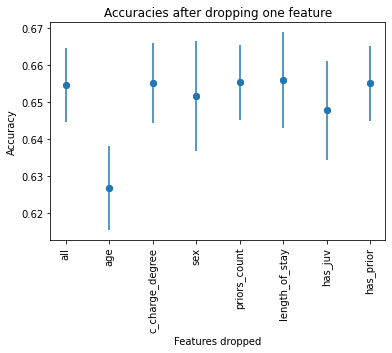

In [22]:
plt.scatter(exp_df['Experiment'], exp_df['Accuracy (mean)']) 
plt.errorbar(exp_df['Experiment'], exp_df['Accuracy (mean)'], yerr=exp_df['Accuracy (std)'], fmt="o")

plt.title('Accuracies after dropping one feature')
plt.ylabel('Accuracy')
plt.xlabel('Features dropped')
plt.xticks(rotation=90)
plt.show()

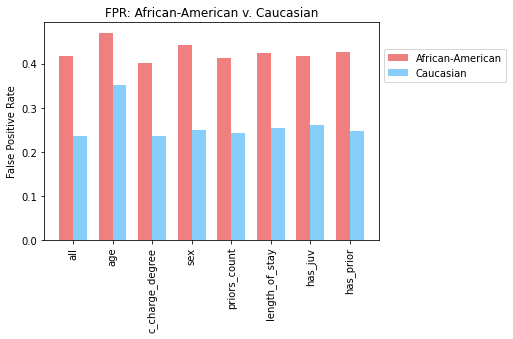

In [42]:
labels = list(exp_df['Experiment'])
x = np.arange(len(exp_df['Experiment']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, exp_df['Black FPR (mean)'], width, label='African-American', color='lightcoral')
rects2 = ax.bar(x + width/2, exp_df['White FPR (mean)'], width, label='Caucasian', color='lightskyblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('False Positive Rate')
ax.set_title('FPR: African-American v. Caucasian')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

#fig.tight_layout()

plt.show()

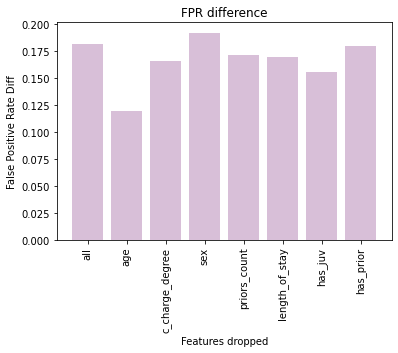

In [38]:
plt.bar(exp_df['Experiment'], exp_df['Black FPR (mean)'] - exp_df['White FPR (mean)'], color='thistle')
plt.title('FPR difference')
plt.xlabel('Features dropped')
plt.ylabel('False Positive Rate Diff')
plt.xticks(rotation=90)
plt.show()